<a href="https://colab.research.google.com/github/karanamrahul/END-Course-NLP/blob/Assignment-4/Model1_Break_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Break Dataset
[Break](https://allenai.github.io/Break/#question-answering-datasets) is a question understanding dataset, aimed at training models to reason over complex questions. It features 83,978 natural language questions, annotated with a new meaning representation, Question Decomposition Meaning Representation (QDMR). Each example has the natural question along with its QDMR representation. Break contains human composed questions, sampled from 10 leading question-answering benchmarks over text, images and databases. This dataset was created by a team of NLP researchers at Tel Aviv University and Allen Institute for AI.

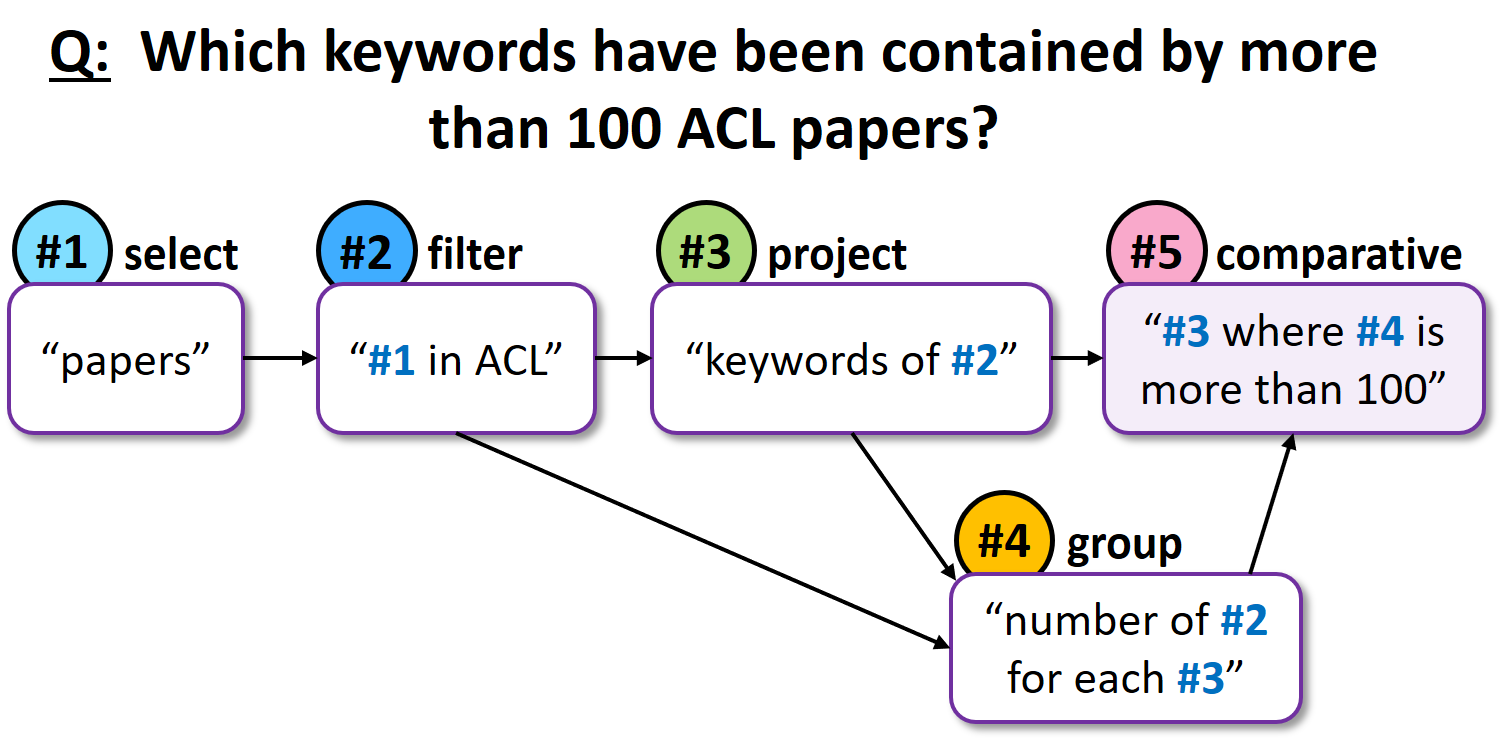

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/Break-dataset/'

In [ ]:
import os
import pandas as pd
validation_data = pd.read_csv(os.path.join(DATA_DIR, 'dev.csv'), sep=',')
train_data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), sep=',')
#test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), sep=',')

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim

from torchtext.data import Field, BucketIterator

from torchtext import data 

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
question = Field(tokenize='spacy',init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

decomposition = Field(tokenize='spacy',init_token='<sos>',
                      eos_token = '<eos>',
                      lower=True)


In [ ]:
fields = [('questions', question),('decompositions',decomposition)]

In [ ]:
example_train = [data.Example.fromlist([train_data.question_text[i],train_data.decomposition[i]], fields) for i in range(train_data.shape[0])] 

In [ ]:
example_val = [data.Example.fromlist([validation_data.question_text[i],validation_data.decomposition[i]],fields) for i in range(validation_data.shape[0])]

In [ ]:
train = data.Dataset(example_train,fields)

In [ ]:
val = data.Dataset(example_val,fields)

In [ ]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of validation examples: {len(val.examples)}")

Number of training examples: 44321
Number of validation examples: 7760


In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# !unzip glove*.zip

In [ ]:
!ls

drive  sample_data


In [ ]:
!pwd

/content


In [ ]:
question.build_vocab(train,min_freq=2, vectors='glove.6B.200d')

decomposition.build_vocab(train,min_freq=2,vectors='glove.6B.200d')


#TEXT.build_vocab(trn, vectors=GloVe(name='6B', dim=300))

.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                          
100%|█████████▉| 399787/400000 [00:26<00:00, 14750.54it/s]

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(question.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(decomposition.vocab)}")

Unique tokens in source (de) vocabulary: 9494
Unique tokens in target (en) vocabulary: 9499


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator = BucketIterator.splits(
    (train, val), 
    batch_size = BATCH_SIZE, 
    device = device,sort=False)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim) #no dropout as only one layer!
        
        self.rnn = nn.GRU(emb_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded) #no cell state!
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        emb_con = torch.cat((embedded, context), dim = 2)
            
        #emb_con = [1, batch size, emb dim + hid dim]
            
        output, hidden = self.rnn(emb_con, hidden)
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        
        #output = [batch size, emb dim + hid dim * 2]
        
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is the context
        context = self.encoder(src)
        
        #context also used as the initial hidden state of the decoder
        hidden = context
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
INPUT_DIM = len(question.vocab)
OUTPUT_DIM = len(decomposition.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9494, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9499, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=9499, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,182,299 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = decomposition.vocab.stoi[decomposition.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.questions
        trg = batch.decompositions

        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.questions
            trg = batch.decompositions

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
print(vars(val.examples[0]))

{'questions': ['what', 'flights', 'are', 'available', 'tomorrow', 'from', 'denver', 'to', 'philadelphia'], 'decompositions': ['return', 'flights', ';', 'return', '#', '1', 'from', ' ', 'denver', ';', 'return', '#', '2', 'to', 'philadelphia', ';', 'return', '#', '3', 'if', ' ', 'available']}


In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 8m 13s
	Train Loss: 3.236 | Train PPL:  25.425
	 Val. Loss: 4.140 |  Val. PPL:  62.826
Epoch: 02 | Time: 8m 17s
	Train Loss: 2.369 | Train PPL:  10.688
	 Val. Loss: 4.227 |  Val. PPL:  68.526
Epoch: 03 | Time: 8m 13s
	Train Loss: 1.958 | Train PPL:   7.082
	 Val. Loss: 4.206 |  Val. PPL:  67.079
Epoch: 04 | Time: 8m 13s
	Train Loss: 1.707 | Train PPL:   5.513
	 Val. Loss: 4.186 |  Val. PPL:  65.791
Epoch: 05 | Time: 8m 17s
	Train Loss: 1.531 | Train PPL:   4.623
	 Val. Loss: 4.126 |  Val. PPL:  61.907
Epoch: 06 | Time: 8m 15s
	Train Loss: 1.367 | Train PPL:   3.923
	 Val. Loss: 4.205 |  Val. PPL:  67.010
Epoch: 07 | Time: 8m 13s
	Train Loss: 1.252 | Train PPL:   3.499
	 Val. Loss: 4.201 |  Val. PPL:  66.772
Epoch: 08 | Time: 8m 19s
	Train Loss: 1.160 | Train PPL:   3.189
	 Val. Loss: 4.180 |  Val. PPL:  65.384
Epoch: 09 | Time: 8m 15s
	Train Loss: 1.061 | Train PPL:   2.889
	 Val. Loss: 4.155 |  Val. PPL:  63.739
Epoch: 10 | Time: 8m 15s
	Train Loss: 0.980 | Train PPL